# Experiment Analysis Framework

**Purpose:** Comprehensive analysis tool for neural network training experiments with focus on data visualization, statistical insights, and actionable recommendations.

**Key Features:**
- Training dynamics visualization with interactive dashboards
- Statistical hyperparameter recommendations with confidence intervals
- Comprehensive benchmarking against baseline models
- James-Stein estimator comparison for weight constraint evaluation
- Residual analysis and error distribution diagnostics
- Cross-run comparison and historical pattern recognition

**Usage:**
1. Run all cells sequentially to load artifacts and generate visualizations
2. Review the comprehensive metric dashboards for training insights
3. Examine hyperparameter recommendations for next experiments
4. Compare binary weight constraints against James-Stein shrinkage

**Dependencies:** TensorFlow, NumPy, Pandas, Matplotlib, Seaborn, SciPy, Scikit-learn

## 1. Setup and Configuration

In [1]:
from __future__ import annotations

import json
import warnings
from pathlib import Path
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython.display import Markdown, display
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Import custom utility module
import experiment_analysis_utils as utils
from james_stein_weight_constraint import JamesSteinWeightConstraint, create_james_stein_model

# Configure display settings
pd.options.display.max_rows = 60
pd.options.display.float_format = '{:,.4f}'.format
warnings.filterwarnings('ignore', category=FutureWarning)

# Set plotting style
sns.set_theme(style="whitegrid", palette="colorblind")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (10, 6)

# Analysis parameters
ANALYSIS_SEED = 42
SAMPLE_SIZE = 512  # Number of samples for prediction analysis
CONFIDENCE_LEVEL = 0.95

np.random.seed(ANALYSIS_SEED)
tf.random.set_seed(ANALYSIS_SEED)

print("✓ Analysis framework initialized successfully")
print(f"Random seed: {ANALYSIS_SEED}")
print(f"TensorFlow version: {tf.__version__}")

✓ Analysis framework initialized successfully
Random seed: 42
TensorFlow version: 2.20.0


### Project Path Detection and Artifact Validation

In [2]:
# Resolve project paths
paths = utils.resolve_project_paths()

display(Markdown(f"**Project root:** `{paths['project_root']}`"))
display(Markdown(f"**Figures directory:** `{paths['figures_dir']}`"))

# Validate artifacts
artifact_status = utils.validate_required_artifacts(paths)

display(Markdown("### Artifact Inventory"))
display(artifact_status)

# Check for missing critical artifacts
missing_artifacts = artifact_status.loc[~artifact_status["exists"] & artifact_status["critical"]]

if not missing_artifacts.empty:
    display(Markdown("⚠️ **Missing critical artifacts detected. Review notes before continuing.**"))
    display(missing_artifacts)
else:
    display(Markdown("✅ All critical artifacts are present."))
    print(f"\nTotal artifacts validated: {len(artifact_status)}")
    print(f"Critical artifacts: {artifact_status['critical'].sum()}")
    print(f"Optional artifacts: {(~artifact_status['critical']).sum()}")

**Project root:** `c:\Users\jesse\OneDrive\Documents\Programming Projects\Neural Network Lab - Python\neural-network-lab-python`

**Figures directory:** `c:\Users\jesse\OneDrive\Documents\Programming Projects\Neural Network Lab - Python\neural-network-lab-python\training_output\analysis\figures`

### Artifact Inventory

,artifact,critical,exists,path,size_bytes,size_readable,modified,note
0,configuration_log,True,True,training_output\configuration_log.csv,"5,770.0000",5.6 KB,2025-10-19 18:06:23.981267452,None
1,loss_history,True,True,training_output\loss_history.csv,"1,378,927.0000",1.3 MB,2025-10-19 18:06:24.073529720,None
2,model_config,True,True,ml_config\model_config.json,359.0000,359.0 B,2025-10-19 17:54:03.208292484,None
3,particle_data,True,True,particle_data.csv,"503,982.0000",492.2 KB,2025-10-19 17:34:58.117898226,Regenerate via data pipeline if missing.
4,scaler_X,True,True,scaler_X.pkl,807.0000,807.0 B,2025-10-19 17:54:19.579668522,Rebuilt automatically through complete_data_pi...
5,scaler_y,True,True,scaler_y.pkl,759.0000,759.0 B,2025-10-19 17:54:19.580667257,Rebuilt automatically through complete_data_pi...
6,training_config,True,True,ml_config\training_config.json,37.0000,37.0 B,2025-10-19 17:41:55.761376381,None
7,training_results,True,True,training_output\training_results.csv,"39,915.0000",39.0 KB,2025-10-19 18:06:23.980264425,None
8,analysis_dir,False,True,training_output\analysis,NaN,None,2025-10-13 18:03:51.432573080,None
9,figures_dir,False,True,training_output\analysis\figures,NaN,None,2025-10-12 02:45:23.258423090,None


✅ All critical artifacts are present.


Total artifacts validated: 10
Critical artifacts: 8
Optional artifacts: 2


## 2. Data Loading Overview

### Load All Required Data

In [3]:
# Load configurations
model_config, training_config, config_history = utils.load_configs(paths)

# Load training logs
analytics = utils.load_training_logs(paths)
loss_records = analytics["loss_records"]
epoch_summary = analytics["epoch_summary"]
results_df = analytics["results"]
merged_metrics = analytics["merged_metrics"]

# Load particle data and scalers
particle_df = utils.load_particle_data(paths)
scaler_X, scaler_y = utils.load_scalers(paths)

# Load model checkpoint
checkpoint_index = utils.list_checkpoint_weights(paths)
model, checkpoint_meta = utils.load_model_checkpoint(
    paths, model_config, training_config, checkpoint_index
)

# Generate predictions
residuals_df, residual_metrics = utils.compute_predictions(
    model, scaler_X, scaler_y, particle_df, sample_size=SAMPLE_SIZE
)

print("✓ All data loaded successfully\n")

# Data quality summary
summary_stats = pd.DataFrame([
    {"Dataset": "Configuration history", "Records": len(config_history), "Status": "✓"},
    {"Dataset": "Loss records", "Records": len(loss_records), "Status": "✓"},
    {"Dataset": "Training results", "Records": len(results_df), "Status": "✓"},
    {"Dataset": "Particle data", "Records": len(particle_df), "Status": "✓"},
    {"Dataset": "Weight checkpoints", "Records": len(checkpoint_index), "Status": "✓"},
    {"Dataset": "Residual predictions", "Records": len(residuals_df), "Status": "✓"}
])

display(Markdown("### Data Loading Summary"))
display(summary_stats)

if checkpoint_meta:
    display(Markdown(f"\n**Loaded model checkpoint:** Epoch {checkpoint_meta['epoch']} | "
                     f"Parameters: {checkpoint_meta['parameter_count']:,}"))

Loaded particle data from c:\Users\jesse\OneDrive\Documents\Programming Projects\Neural Network Lab - Python\neural-network-lab-python\particle_data.csv (2000 particles)

✓ All data loaded successfully



c:\Users\jesse\OneDrive\Documents\Programming Projects\Neural Network Lab - Python\neural-network-lab-python\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Data Loading Summary

,Dataset,Records,Status
0,Configuration history,21,✓
1,Loss records,16000,✓
2,Training results,200,✓
3,Particle data,2000,✓
4,Weight checkpoints,207,✓
5,Residual predictions,512,✓



**Loaded model checkpoint:** Epoch 1999 | Parameters: 12,118

### Quick Data Quality Checks

In [4]:
quality_checks = []

# Check for missing values
missing_count = particle_df.isna().sum().sum()
quality_checks.append({
    "Check": "No missing values in particle data",
    "Result": "PASS" if missing_count == 0 else "FAIL",
    "Details": f"{missing_count} missing values"
})

# Check training convergence
final_val_loss = results_df.iloc[-1]["val_loss"]
best_val_loss = results_df["val_loss"].min()
convergence_gap = final_val_loss - best_val_loss
quality_checks.append({
    "Check": "Training convergence (final vs best < 0.01)",
    "Result": "PASS" if convergence_gap < 0.01 else "WARNING",
    "Details": f"Gap: {convergence_gap:.4f}"
})

# Check train/val gap
final_gap = results_df.iloc[-1]["train_val_gap"]
quality_checks.append({
    "Check": "No severe overfitting (train/val gap < 0.1)",
    "Result": "PASS" if final_gap < 0.1 else "WARNING",
    "Details": f"Gap: {final_gap:.4f}"
})

# Check checkpoint availability
quality_checks.append({
    "Check": "Model checkpoint loaded successfully",
    "Result": "PASS" if model is not None else "FAIL",
    "Details": f"Epoch {checkpoint_meta['epoch'] if checkpoint_meta else 'N/A'}"
})

# Check prediction quality
mae = residual_metrics.get("mae", float('inf'))
quality_checks.append({
    "Check": "Reasonable prediction accuracy (MAE < 1.0)",
    "Result": "PASS" if mae < 1.0 else "WARNING",
    "Details": f"MAE: {mae:.4f}"
})

quality_df = pd.DataFrame(quality_checks)

display(Markdown("### Data Quality Checks"))
display(quality_df)

pass_count = (quality_df["Result"] == "PASS").sum()
print(f"\n{pass_count}/{len(quality_checks)} checks passed")

### Data Quality Checks

,Check,Result,Details
0,No missing values in particle data,PASS,0 missing values
1,Training convergence (final vs best < 0.01),WARNING,Gap: 0.0192
2,No severe overfitting (train/val gap < 0.1),PASS,Gap: -0.0135
3,Model checkpoint loaded successfully,PASS,Epoch 1999
4,Reasonable prediction accuracy (MAE < 1.0),WARNING,MAE: 2.2493



3/5 checks passed


## 3. Training Dynamics Visualization

### Comprehensive Training Dashboard

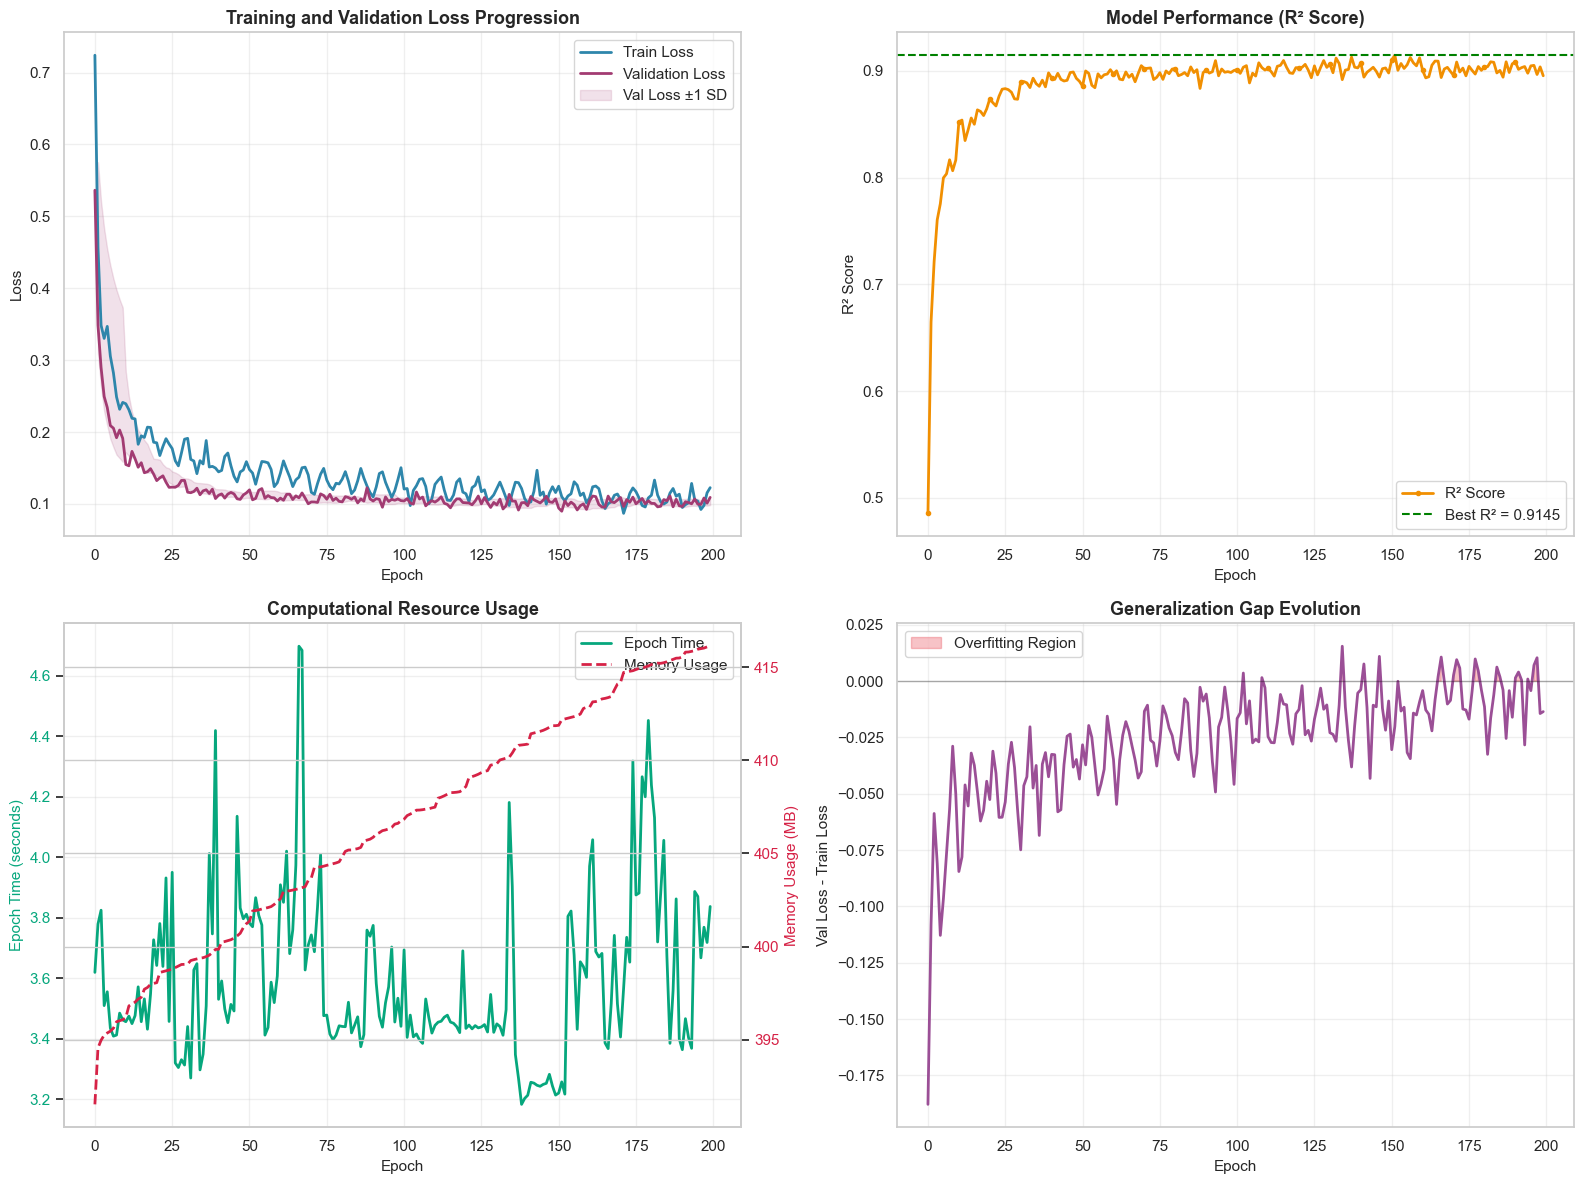

✓ Saved training dynamics dashboard to `training_dynamics_dashboard.png`

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: Training and validation loss curves with confidence bands
ax1 = axes[0, 0]
ax1.plot(results_df["epoch"], results_df["train_loss"], label="Train Loss", linewidth=2, color="#2E86AB")
ax1.plot(results_df["epoch"], results_df["val_loss"], label="Validation Loss", linewidth=2, color="#A23B72")

# Add rolling standard deviation as confidence band
val_std = results_df["val_loss"].rolling(10, min_periods=1).std()
val_mean = results_df["val_loss"].rolling(10, min_periods=1).mean()
ax1.fill_between(results_df["epoch"], val_mean - val_std, val_mean + val_std, 
                  color="#A23B72", alpha=0.15, label="Val Loss ±1 SD")

ax1.set_xlabel("Epoch", fontsize=11)
ax1.set_ylabel("Loss", fontsize=11)
ax1.set_title("Training and Validation Loss Progression", fontsize=13, fontweight="bold")
ax1.legend(loc="best", frameon=True)
ax1.grid(True, alpha=0.3)

# Subplot 2: R² score progression
ax2 = axes[0, 1]
ax2.plot(results_df["epoch"], results_df["r2_score"], label="R² Score", 
         linewidth=2, color="#F18F01", marker="o", markersize=3, markevery=10)
ax2.axhline(results_df["r2_score"].max(), linestyle="--", color="green", 
            linewidth=1.5, label=f"Best R² = {results_df['r2_score'].max():.4f}")
ax2.set_xlabel("Epoch", fontsize=11)
ax2.set_ylabel("R² Score", fontsize=11)
ax2.set_title("Model Performance (R² Score)", fontsize=13, fontweight="bold")
ax2.legend(loc="best", frameon=True)
ax2.grid(True, alpha=0.3)

# Subplot 3: Epoch time and memory usage
ax3 = axes[1, 0]
ax3_twin = ax3.twinx()

line1 = ax3.plot(results_df["epoch"], results_df["epoch_time"], 
                 label="Epoch Time", linewidth=2, color="#06A77D")
line2 = ax3_twin.plot(results_df["epoch"], results_df["memory_mb"], 
                      label="Memory Usage", linewidth=2, color="#D62246", linestyle="--")

ax3.set_xlabel("Epoch", fontsize=11)
ax3.set_ylabel("Epoch Time (seconds)", fontsize=11, color="#06A77D")
ax3_twin.set_ylabel("Memory Usage (MB)", fontsize=11, color="#D62246")
ax3.set_title("Computational Resource Usage", fontsize=13, fontweight="bold")

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc="best", frameon=True)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='y', labelcolor="#06A77D")
ax3_twin.tick_params(axis='y', labelcolor="#D62246")

# Subplot 4: Train/val gap evolution
ax4 = axes[1, 1]
ax4.plot(results_df["epoch"], results_df["train_val_gap"], 
         linewidth=2, color="#9B4F96")
ax4.axhline(0, linestyle="-", color="black", linewidth=1, alpha=0.3)
ax4.fill_between(results_df["epoch"], 0, results_df["train_val_gap"], 
                  where=(results_df["train_val_gap"] > 0), 
                  color="#E63946", alpha=0.3, label="Overfitting Region")
ax4.set_xlabel("Epoch", fontsize=11)
ax4.set_ylabel("Val Loss - Train Loss", fontsize=11)
ax4.set_title("Generalization Gap Evolution", fontsize=13, fontweight="bold")
ax4.legend(loc="best", frameon=True)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
dashboard_path = paths["figures_dir"] / "training_dynamics_dashboard.png"
plt.savefig(dashboard_path, dpi=300, bbox_inches="tight")
plt.show()

display(Markdown(f"✓ Saved training dynamics dashboard to `{dashboard_path.name}`"))

### Learning Rate and Loss Correlation Analysis

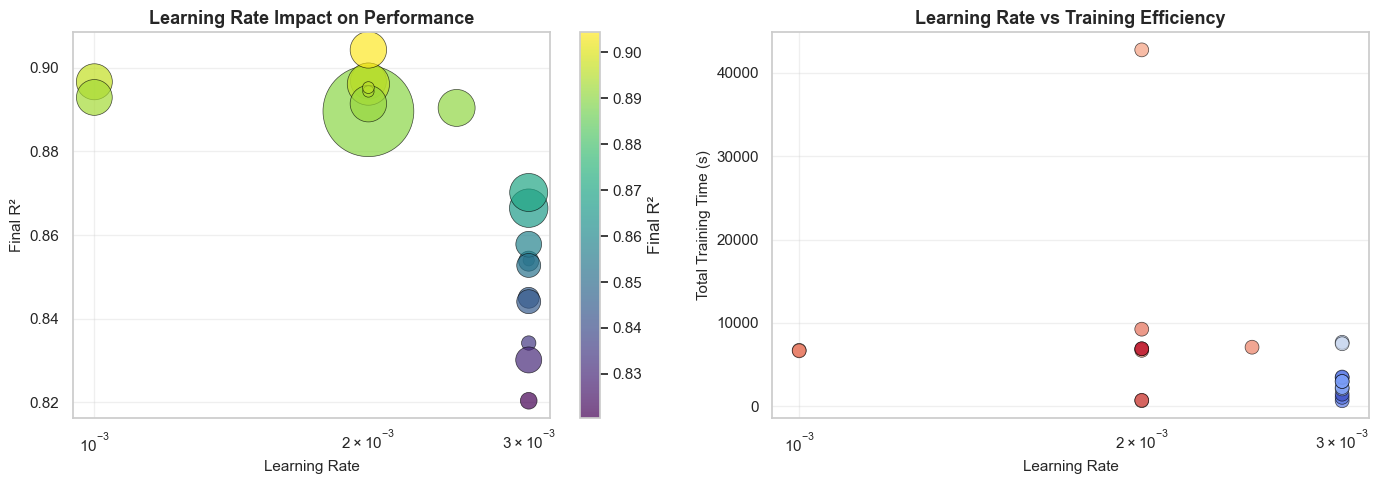

✓ Saved learning rate analysis to `learning_rate_analysis.png`

In [6]:
if not config_history.empty and "learning_rate" in config_history.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Learning rate vs final R²
    ax1 = axes[0]
    scatter = ax1.scatter(
        config_history["learning_rate"],
        config_history["final_r2"],
        s=config_history.get("total_training_time", 100) / 10,
        c=config_history["final_r2"],
        cmap="viridis",
        alpha=0.7,
        edgecolors="black",
        linewidth=0.5
    )
    ax1.set_xlabel("Learning Rate", fontsize=11)
    ax1.set_ylabel("Final R²", fontsize=11)
    ax1.set_title("Learning Rate Impact on Performance", fontsize=13, fontweight="bold")
    ax1.set_xscale("log")
    ax1.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax1, label="Final R²")
    
    # Learning rate vs training time
    if "total_training_time" in config_history.columns:
        ax2 = axes[1]
        ax2.scatter(
            config_history["learning_rate"],
            config_history["total_training_time"],
            s=100,
            c=config_history["best_r2"],
            cmap="coolwarm",
            alpha=0.7,
            edgecolors="black",
            linewidth=0.5
        )
        ax2.set_xlabel("Learning Rate", fontsize=11)
        ax2.set_ylabel("Total Training Time (s)", fontsize=11)
        ax2.set_title("Learning Rate vs Training Efficiency", fontsize=13, fontweight="bold")
        ax2.set_xscale("log")
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    lr_analysis_path = paths["figures_dir"] / "learning_rate_analysis.png"
    plt.savefig(lr_analysis_path, dpi=300, bbox_inches="tight")
    plt.show()
    
    display(Markdown(f"✓ Saved learning rate analysis to `{lr_analysis_path.name}`"))
else:
    print("⚠ Insufficient historical data for learning rate analysis")

## 4. Model Performance Analysis

### Comprehensive Metric Dashboard

In [7]:
performance_summary = utils.summarize_run_performance(results_df, epoch_summary)

display(Markdown("### Key Performance Indicators"))
display(performance_summary)

if residual_metrics:
    display(Markdown("### Overall Residual Metrics"))
    overall_metrics = {k: v for k, v in residual_metrics.items() if k != "targets"}
    display(pd.Series(overall_metrics, name="value"))
    
    display(Markdown("### Per-Target Performance Breakdown"))
    target_metrics_df = pd.DataFrame(residual_metrics["targets"]).T
    target_metrics_df["relative_error"] = target_metrics_df["mae"] / (target_metrics_df["rmse"] + 1e-8)
    target_metrics_df = target_metrics_df.sort_values("mae", ascending=False)
    display(target_metrics_df)

### Key Performance Indicators

,metric,value,notes
0,Best validation loss,0.0898,Epoch 151
1,Final validation loss,0.1090,Train gap -0.0135
2,Validation improvement,0.4465,Drop from first to best epoch
3,Validation stability (std last 5 epochs),0.0520,Lower is more stable
4,Average epoch time (last 10 epochs),3.6349,Supports batch-size experiments
5,Peak R²,0.9145,Epoch 151
6,Total recorded training time,718.8145,seconds


### Overall Residual Metrics

samples                512.0000
mae                      2.2493
rmse                     3.7880
residual_norm_median     6.0795
residual_norm_p95       17.5743
Name: value, dtype: float64

### Per-Target Performance Breakdown

,mae,rmse,bias,relative_error
kinetic_energy,4.8621,6.7640,-2.7304,0.7188
final_position_y,2.5609,3.7125,-0.7589,0.6898
final_position_x,2.5398,3.6904,-0.7088,0.6882
trajectory_length,2.1061,3.0717,-1.1698,0.6856
final_velocity_x,0.7545,1.4245,-0.1361,0.5296
final_velocity_y,0.6724,1.2147,0.0912,0.5535


### Residual Analysis Suite

C:\Users\jesse\AppData\Local\Temp\ipykernel_16084\96556669.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(residual_data, labels=labels, patch_artist=True,


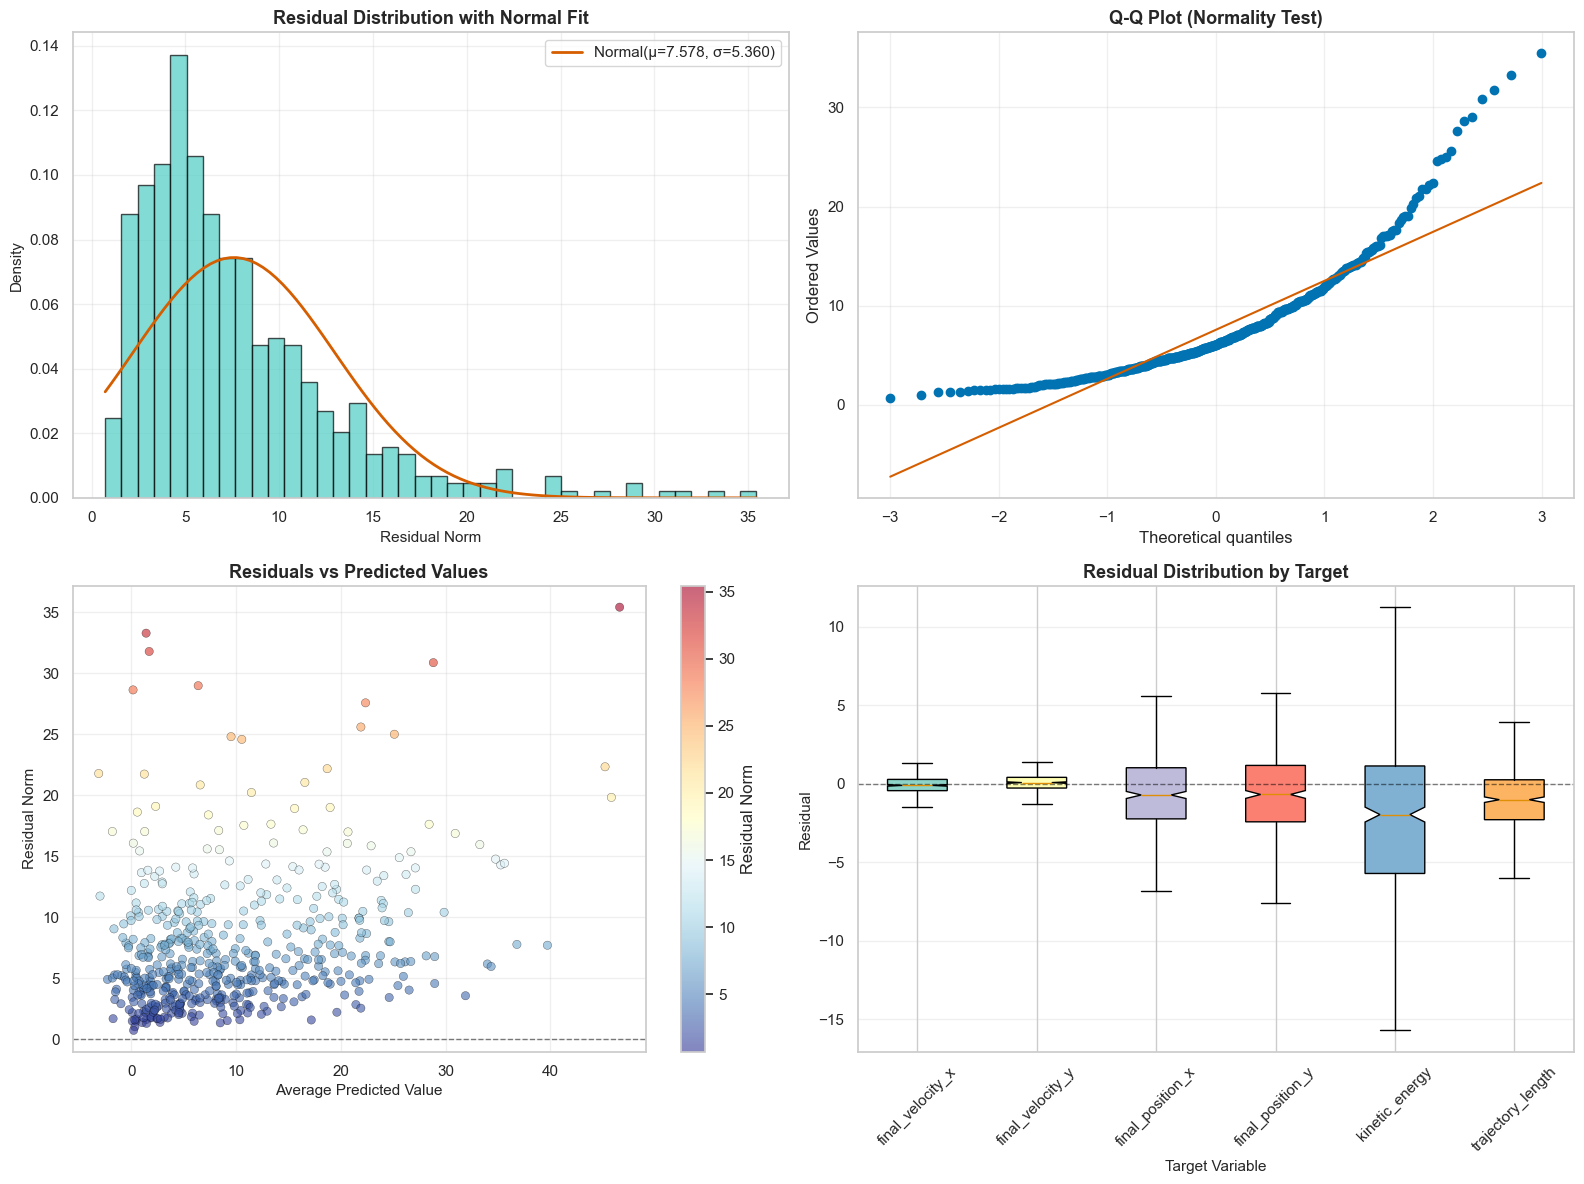

✓ Saved residual analysis suite to `residual_analysis_suite.png`


Shapiro-Wilk normality test: p-value = 0.0000
Residuals appear to be NOT normally distributed (α=0.05)


In [8]:
if not residuals_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Subplot 1: Residual distribution histogram with normal curve
    ax1 = axes[0, 0]
    residual_norms = residuals_df["residual_norm"]
    ax1.hist(residual_norms, bins=40, density=True, alpha=0.7, color="#4ECDC4", edgecolor="black")
    
    # Fit and plot normal distribution
    mu, sigma = residual_norms.mean(), residual_norms.std()
    x = np.linspace(residual_norms.min(), residual_norms.max(), 100)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label=f'Normal(μ={mu:.3f}, σ={sigma:.3f})')
    
    ax1.set_xlabel("Residual Norm", fontsize=11)
    ax1.set_ylabel("Density", fontsize=11)
    ax1.set_title("Residual Distribution with Normal Fit", fontsize=13, fontweight="bold")
    ax1.legend(loc="best", frameon=True)
    ax1.grid(True, alpha=0.3)
    
    # Subplot 2: Q-Q plot for normality testing
    ax2 = axes[0, 1]
    stats.probplot(residual_norms, dist="norm", plot=ax2)
    ax2.set_title("Q-Q Plot (Normality Test)", fontsize=13, fontweight="bold")
    ax2.grid(True, alpha=0.3)
    
    # Subplot 3: Residuals vs predicted values
    ax3 = axes[1, 0]
    
    # Calculate average predicted value across all targets
    pred_cols = [col for col in residuals_df.columns if col.startswith("pred_")]
    predicted_avg = residuals_df[pred_cols].mean(axis=1)
    
    scatter = ax3.scatter(predicted_avg, residual_norms, 
                         c=residual_norms, cmap="RdYlBu_r", 
                         alpha=0.6, edgecolors="black", linewidth=0.3)
    ax3.axhline(0, linestyle="--", color="black", linewidth=1, alpha=0.5)
    ax3.set_xlabel("Average Predicted Value", fontsize=11)
    ax3.set_ylabel("Residual Norm", fontsize=11)
    ax3.set_title("Residuals vs Predicted Values", fontsize=13, fontweight="bold")
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label="Residual Norm")
    
    # Subplot 4: Per-target residual boxplots
    ax4 = axes[1, 1]
    residual_cols = [col for col in residuals_df.columns 
                     if col.startswith("residual_") and not col.endswith(("norm", "_z"))]
    
    residual_data = []
    labels = []
    
    for col in residual_cols:
        residual_data.append(residuals_df[col])
        # Extract target name (remove 'residual_' prefix)
        labels.append(col.replace("residual_", ""))
    
    bp = ax4.boxplot(residual_data, labels=labels, patch_artist=True, 
                     notch=True, showfliers=False)
    
    # Color boxes
    colors = sns.color_palette("Set3", len(residual_data))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax4.axhline(0, linestyle="--", color="black", linewidth=1, alpha=0.5)
    ax4.set_xlabel("Target Variable", fontsize=11)
    ax4.set_ylabel("Residual", fontsize=11)
    ax4.set_title("Residual Distribution by Target", fontsize=13, fontweight="bold")
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    residual_suite_path = paths["figures_dir"] / "residual_analysis_suite.png"
    plt.savefig(residual_suite_path, dpi=300, bbox_inches="tight")
    plt.show()
    
    display(Markdown(f"✓ Saved residual analysis suite to `{residual_suite_path.name}`"))
    
    # Normality test
    _, p_value = stats.shapiro(residual_norms[:min(len(residual_norms), 5000)])
    normality_result = "normally distributed" if p_value > 0.05 else "NOT normally distributed"
    print(f"\nShapiro-Wilk normality test: p-value = {p_value:.4f}")
    print(f"Residuals appear to be {normality_result} (α=0.05)")

### Prediction Scatter Plots (Actual vs Predicted)

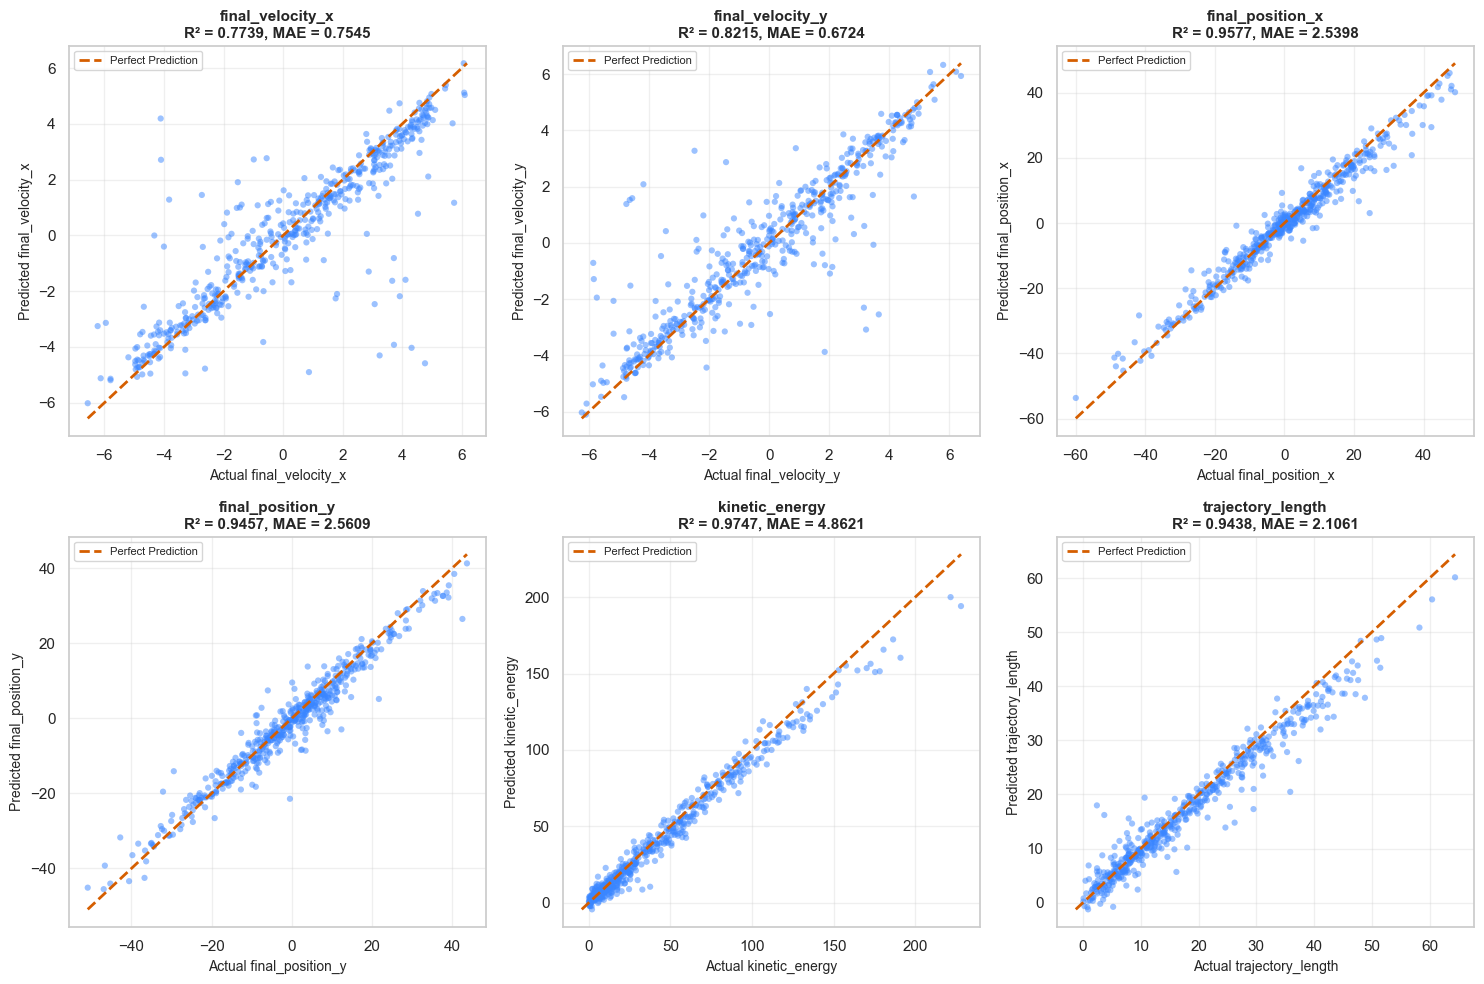

✓ Saved prediction scatter plots to `prediction_scatter_plots.png`

In [9]:
if not residuals_df.empty:
    # Get unique target names
    targets = [col.replace("actual_", "") for col in residuals_df.columns if col.startswith("actual_")]
    
    # Create subplots (2 rows, 3 columns for 6 targets)
    n_targets = len(targets)
    n_cols = 3
    n_rows = (n_targets + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_targets > 1 else [axes]
    
    for idx, target in enumerate(targets):
        ax = axes[idx]
        
        actual_col = f"actual_{target}"
        pred_col = f"pred_{target}"
        
        actual = residuals_df[actual_col]
        predicted = residuals_df[pred_col]
        
        # Scatter plot
        ax.scatter(actual, predicted, alpha=0.5, s=20, edgecolors="none", color="#3A86FF")
        
        # Perfect prediction line
        min_val = min(actual.min(), predicted.min())
        max_val = max(actual.max(), predicted.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label="Perfect Prediction")
        
        # Calculate R²
        r2 = r2_score(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        
        ax.set_xlabel(f"Actual {target}", fontsize=10)
        ax.set_ylabel(f"Predicted {target}", fontsize=10)
        ax.set_title(f"{target}\nR² = {r2:.4f}, MAE = {mae:.4f}", fontsize=11, fontweight="bold")
        ax.legend(loc="best", frameon=True, fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_targets, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    scatter_path = paths["figures_dir"] / "prediction_scatter_plots.png"
    plt.savefig(scatter_path, dpi=300, bbox_inches="tight")
    plt.show()
    
    display(Markdown(f"✓ Saved prediction scatter plots to `{scatter_path.name}`"))

## 5. Benchmarking and Comparison

### Baseline Model Comparison

### Baseline Model Comparison

,Model,R²,MAE,RMSE,MAPE (%)
0,Advanced NN (Binary Constraints),0.8847,2.4860,4.1078,104.3627
1,Linear Regression,0.4795,8.4030,15.8343,231.4379
2,Mean Baseline,-0.0065,12.6795,21.3863,197.7972


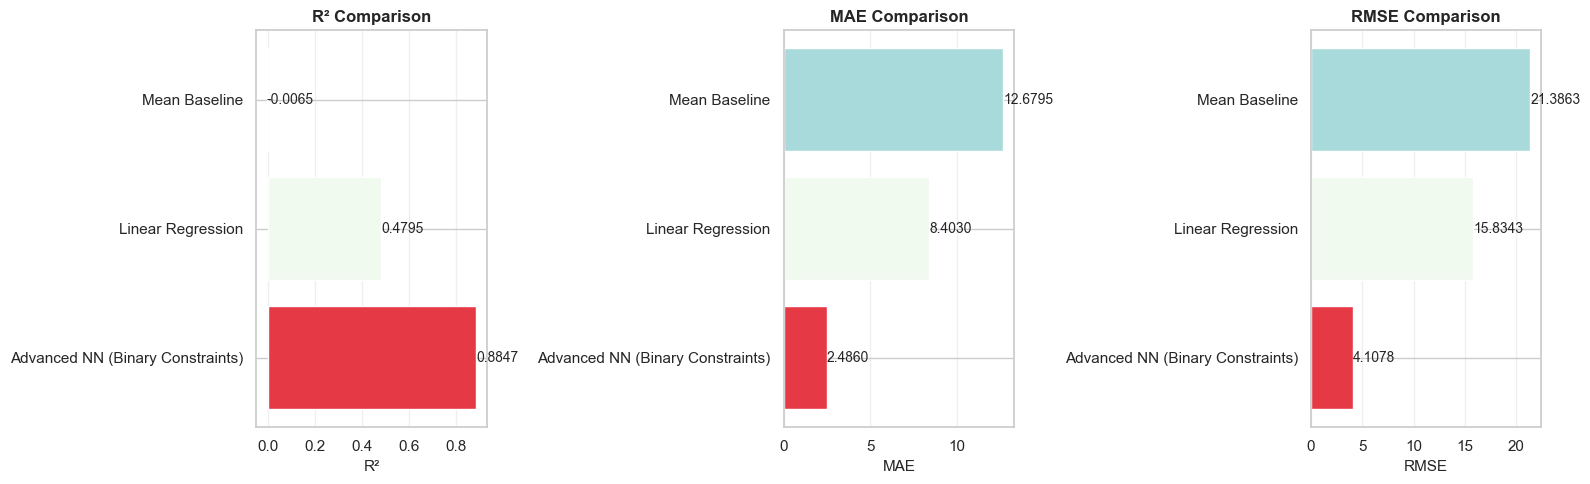

✓ Saved baseline comparison to `baseline_comparison.png`


Model improvement over mean baseline: 88.55% of possible improvement


In [10]:
# Prepare comparison with baseline models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Prepare data
X = particle_df[utils.INPUT_FEATURES].values
y = particle_df[utils.OUTPUT_TARGETS].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=ANALYSIS_SEED
)

# Scale data
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.transform(y_train)

# Mean baseline
mean_predictions = np.tile(y_train.mean(axis=0), (len(y_test), 1))

# Linear regression baseline
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_predictions = lr_model.predict(X_test_scaled)

# Current model predictions
if model is not None:
    model_predictions_scaled = model.predict(X_test_scaled, verbose=0)
    model_predictions = scaler_y.inverse_transform(model_predictions_scaled)
else:
    model_predictions = mean_predictions

# Compute metrics for each baseline
baseline_results = []

for name, preds in [
    ("Mean Baseline", mean_predictions),
    ("Linear Regression", lr_predictions),
    ("Advanced NN (Binary Constraints)", model_predictions)
]:
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mape = np.mean(np.abs((y_test - preds) / (y_test + 1e-8))) * 100
    
    baseline_results.append({
        "Model": name,
        "R²": r2,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

baseline_comparison_df = pd.DataFrame(baseline_results)
baseline_comparison_df = baseline_comparison_df.sort_values("R²", ascending=False).reset_index(drop=True)

display(Markdown("### Baseline Model Comparison"))
display(baseline_comparison_df)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = ["R²", "MAE", "RMSE"]
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    bars = ax.barh(baseline_comparison_df["Model"], baseline_comparison_df[metric], 
                   color=["#E63946", "#F1FAEE", "#A8DADC"])
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.4f}', ha='left', va='center', fontsize=10)
    
    ax.set_xlabel(metric, fontsize=11)
    ax.set_title(f"{metric} Comparison", fontsize=12, fontweight="bold")
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
baseline_comp_path = paths["figures_dir"] / "baseline_comparison.png"
plt.savefig(baseline_comp_path, dpi=300, bbox_inches="tight")
plt.show()

display(Markdown(f"✓ Saved baseline comparison to `{baseline_comp_path.name}`"))

# Performance improvement calculation
baseline_r2 = baseline_comparison_df.loc[baseline_comparison_df["Model"] == "Mean Baseline", "R²"].values[0]
model_r2 = baseline_comparison_df.loc[baseline_comparison_df["Model"] == "Advanced NN (Binary Constraints)", "R²"].values[0]
improvement = ((model_r2 - baseline_r2) / (1 - baseline_r2)) * 100

print(f"\nModel improvement over mean baseline: {improvement:.2f}% of possible improvement")

### James-Stein Estimator Comparison

Train three model variants with identical hyperparameters to rigorously evaluate weight constraint effectiveness:
1. **Binary Weight Constraints** (current approach)
2. **James-Stein Shrinkage** (statistical benchmark)
3. **No Constraints** (baseline)

In [11]:
# Train three model variants for comparison
from advanced_neural_network import AdvancedNeuralNetwork

print("Training model variants for James-Stein comparison...")
print("This may take several minutes depending on dataset size and epochs.\n")

# Common hyperparameters
common_config = {
    "hidden_layers": model_config.get("hidden_layers", [64, 32, 16]),
    "activation": model_config.get("activation", "relu"),
    "dropout_rate": model_config.get("dropout_rate", 0.0),
    "learning_rate": model_config.get("learning_rate", 0.001),
    "epochs": min(training_config.get("epochs", 50), 50),  # Limit to 50 epochs for comparison
    "batch_size": training_config.get("batch_size", 16),
    "validation_split": 0.2
}

input_shape = (len(utils.INPUT_FEATURES),)
output_shape = len(utils.OUTPUT_TARGETS)

# Prepare training data
X_train_full = scaler_X.transform(particle_df[utils.INPUT_FEATURES].values)
y_train_full = scaler_y.transform(particle_df[utils.OUTPUT_TARGETS].values)

# Split into train/val
val_split = int(len(X_train_full) * 0.8)
X_train_comp = X_train_full[:val_split]
X_val_comp = X_train_full[val_split:]
y_train_comp = y_train_full[:val_split]
y_val_comp = y_train_full[val_split:]

comparison_results = {}

# Model 1: Binary Weight Constraints
print("1/3: Training Binary Weight Constraints model...")
tf.keras.backend.clear_session()
tf.random.set_seed(ANALYSIS_SEED)

config_binary = common_config.copy()
config_binary.update({
    "enable_binary_precision_max": True,
    "max_binary_digits": 5,
    "enable_weight_oscillation_dampener": True,
    "use_adaptive_oscillation_dampener": True,
})

model_binary = AdvancedNeuralNetwork(input_shape, output_shape, config_binary)

# Compile model with loss and metrics
model_binary.model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=common_config["learning_rate"]),
    loss='mse',
    metrics=['mae']
)

history_binary = model_binary.model.fit(
    X_train_comp, y_train_comp,
    validation_data=(X_val_comp, y_val_comp),
    epochs=common_config["epochs"],
    batch_size=common_config["batch_size"],
    verbose=0
)

comparison_results["Binary Constraints"] = {
    "model": model_binary.model,
    "history": history_binary,
    "final_val_loss": history_binary.history["val_loss"][-1],
    "final_val_mae": history_binary.history["val_mae"][-1],
    "best_val_loss": min(history_binary.history["val_loss"]),
    "convergence_epoch": np.argmin(history_binary.history["val_loss"]) + 1
}

print(f"   ✓ Final validation loss: {comparison_results['Binary Constraints']['final_val_loss']:.4f}\n")

# Model 2: James-Stein Shrinkage
print("2/3: Training James-Stein Shrinkage model...")
tf.keras.backend.clear_session()
tf.random.set_seed(ANALYSIS_SEED)

model_js = create_james_stein_model(
    input_shape=input_shape,
    output_shape=output_shape,
    hidden_layers=common_config["hidden_layers"],
    activation=common_config["activation"],
    dropout_rate=common_config["dropout_rate"],
    learning_rate=common_config["learning_rate"]
)

history_js = model_js.fit(
    X_train_comp, y_train_comp,
    validation_data=(X_val_comp, y_val_comp),
    epochs=common_config["epochs"],
    batch_size=common_config["batch_size"],
    verbose=0
)

comparison_results["James-Stein"] = {
    "model": model_js,
    "history": history_js,
    "final_val_loss": history_js.history["val_loss"][-1],
    "final_val_mae": history_js.history["val_mae"][-1],
    "best_val_loss": min(history_js.history["val_loss"]),
    "convergence_epoch": np.argmin(history_js.history["val_loss"]) + 1
}

print(f"   ✓ Final validation loss: {comparison_results['James-Stein']['final_val_loss']:.4f}\n")

# Model 3: No Constraints (Baseline)
print("3/3: Training No Constraints baseline model...")
tf.keras.backend.clear_session()
tf.random.set_seed(ANALYSIS_SEED)

model_baseline = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
])

for units in common_config["hidden_layers"]:
    model_baseline.add(tf.keras.layers.Dense(units, activation=common_config["activation"]))
    if common_config["dropout_rate"] > 0:
        model_baseline.add(tf.keras.layers.Dropout(common_config["dropout_rate"]))

model_baseline.add(tf.keras.layers.Dense(output_shape))

model_baseline.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=common_config["learning_rate"]),
    loss='mse',
    metrics=['mae']
)

history_baseline = model_baseline.fit(
    X_train_comp, y_train_comp,
    validation_data=(X_val_comp, y_val_comp),
    epochs=common_config["epochs"],
    batch_size=common_config["batch_size"],
    verbose=0
)

comparison_results["No Constraints"] = {
    "model": model_baseline,
    "history": history_baseline,
    "final_val_loss": history_baseline.history["val_loss"][-1],
    "final_val_mae": history_baseline.history["val_mae"][-1],
    "best_val_loss": min(history_baseline.history["val_loss"]),
    "convergence_epoch": np.argmin(history_baseline.history["val_loss"]) + 1
}

print(f"   ✓ Final validation loss: {comparison_results['No Constraints']['final_val_loss']:.4f}\n")

print("✓ All models trained successfully")

Training model variants for James-Stein comparison...
This may take several minutes depending on dataset size and epochs.

1/3: Training Binary Weight Constraints model...
   ✓ Final validation loss: 0.1019

2/3: Training James-Stein Shrinkage model...
   ✓ Final validation loss: 1.0650

3/3: Training No Constraints baseline model...
   ✓ Final validation loss: 0.1002

✓ All models trained successfully


### James-Stein Comparison Visualization and Statistical Analysis

C:\Users\jesse\AppData\Local\Temp\ipykernel_16084\3172895799.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax5.set_xticklabels(list(comparison_results.keys()), rotation=15, ha="right")
C:\Users\jesse\AppData\Local\Temp\ipykernel_16084\3172895799.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax6.set_xticklabels(list(comparison_results.keys()), rotation=15, ha="right")


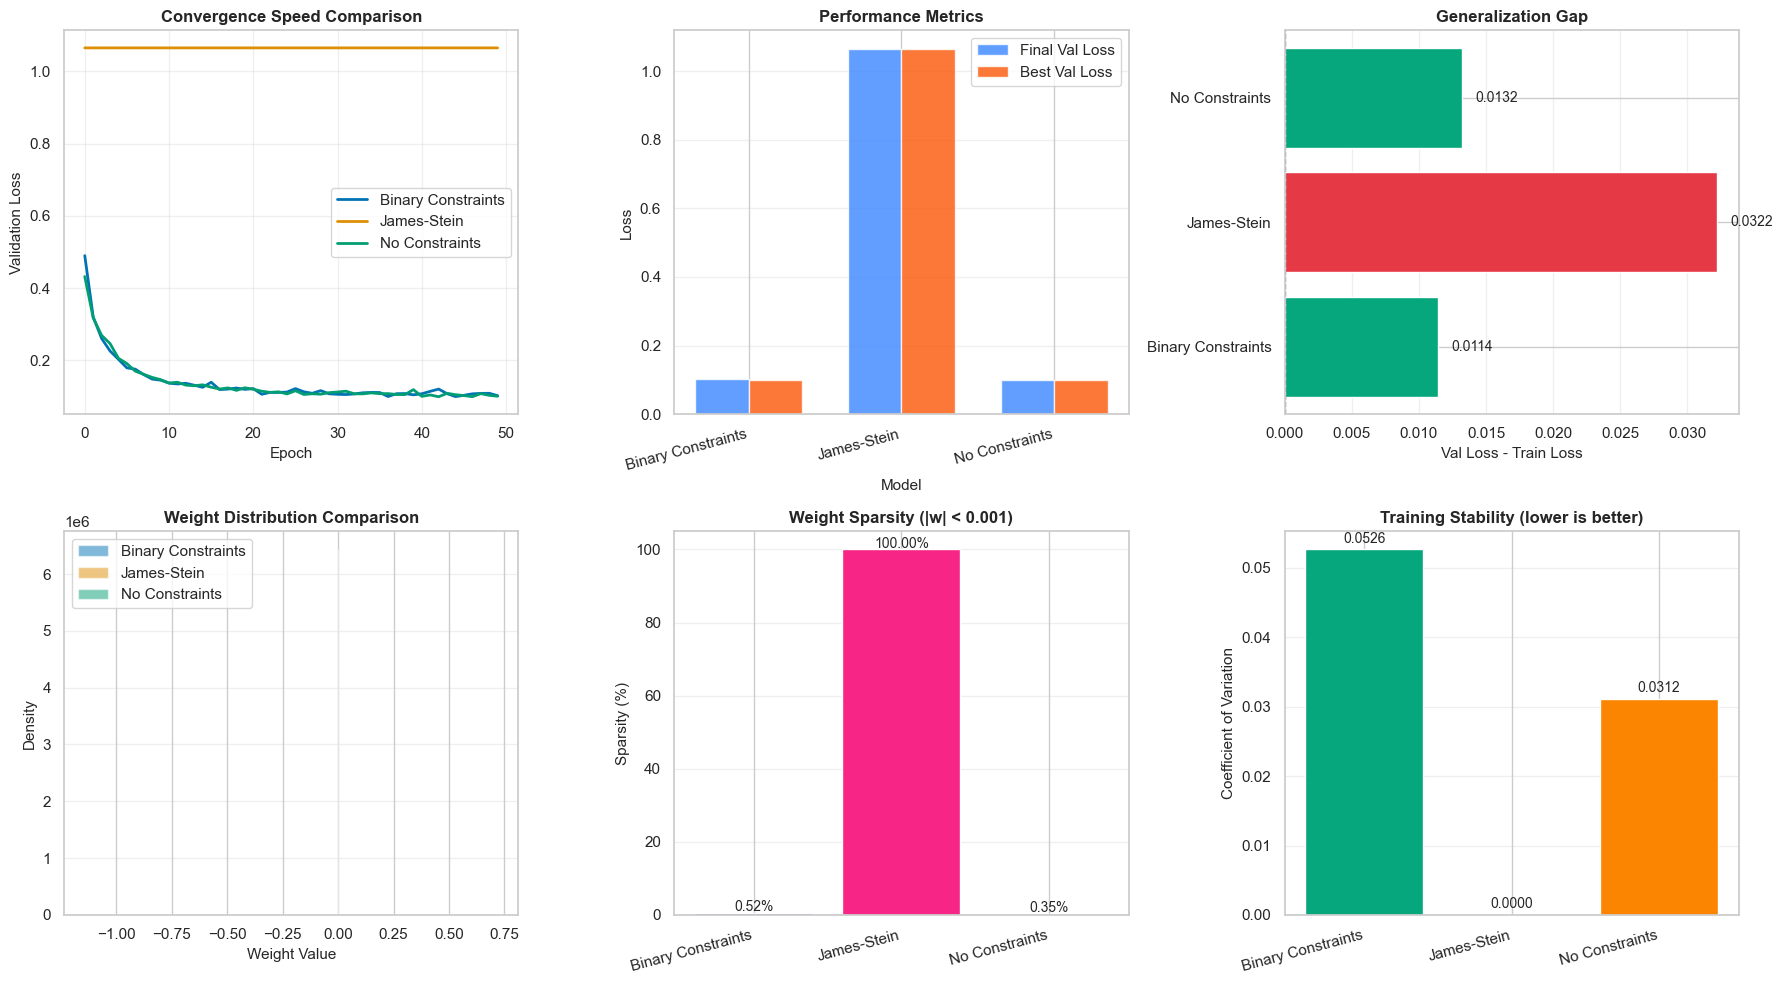

✓ Saved James-Stein comparison to `james_stein_comparison.png`

### James-Stein Comparison Summary Table

,Model,Best Val Loss,Final Val Loss,Final Val MAE,Convergence Epoch,Generalization Gap,Weight Sparsity (%),Training Stability (CV)
0,Binary Constraints,0.0993,0.1019,0.1979,45,0.0114,0.5222,0.0526
1,James-Stein,1.0649,1.0650,0.8361,2,0.0322,100.0000,0.0000
2,No Constraints,0.0989,0.1002,0.1896,43,0.0132,0.3454,0.0312


### Statistical Significance Testing

,Comparison,Test,Statistic,P-Value,Significant (α=0.05),Interpretation
0,Binary Constraints vs James-Stein,Wilcoxon Signed-Rank,0.0000,0.0000,Yes,Binary Constraints are significantly different



Effect size (Cohen's d): -20.0187
Mean difference: -0.9278
Effect interpretation: large


### Recommendations

✓ Best performing model: No Constraints
  - Best validation loss: 0.0989
  - Converged at epoch: 43

**When to use each approach:**
• Binary Constraints: When discrete precision matters and you want controlled weight updates
• James-Stein: When shrinkage toward zero is beneficial and you want statistical optimality
• No Constraints: When full model expressiveness is critical and overfitting is not a concern


In [12]:
# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Subplot 1: Convergence comparison
ax1 = axes[0, 0]
for name, data in comparison_results.items():
    ax1.plot(data["history"].history["val_loss"], label=name, linewidth=2)

ax1.set_xlabel("Epoch", fontsize=11)
ax1.set_ylabel("Validation Loss", fontsize=11)
ax1.set_title("Convergence Speed Comparison", fontsize=12, fontweight="bold")
ax1.legend(loc="best", frameon=True)
ax1.grid(True, alpha=0.3)

# Subplot 2: Performance metrics comparison
ax2 = axes[0, 1]
metrics_data = {
    "Model": list(comparison_results.keys()),
    "Final Val Loss": [data["final_val_loss"] for data in comparison_results.values()],
    "Best Val Loss": [data["best_val_loss"] for data in comparison_results.values()],
    "Convergence Epoch": [data["convergence_epoch"] for data in comparison_results.values()]
}

x = np.arange(len(metrics_data["Model"]))
width = 0.35

bars1 = ax2.bar(x - width/2, metrics_data["Final Val Loss"], width, 
                label="Final Val Loss", color="#3A86FF", alpha=0.8)
bars2 = ax2.bar(x + width/2, metrics_data["Best Val Loss"], width, 
                label="Best Val Loss", color="#FB5607", alpha=0.8)

ax2.set_xlabel("Model", fontsize=11)
ax2.set_ylabel("Loss", fontsize=11)
ax2.set_title("Performance Metrics", fontsize=12, fontweight="bold")
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_data["Model"], rotation=15, ha="right")
ax2.legend(loc="best", frameon=True)
ax2.grid(True, alpha=0.3, axis='y')

# Subplot 3: Generalization gap
ax3 = axes[0, 2]
gen_gaps = []
for name, data in comparison_results.items():
    final_train = data["history"].history["loss"][-1]
    final_val = data["final_val_loss"]
    gen_gaps.append(final_val - final_train)

bars = ax3.barh(list(comparison_results.keys()), gen_gaps, 
                color=["#06A77D" if gap < 0.02 else "#E63946" for gap in gen_gaps])

for i, (bar, gap) in enumerate(zip(bars, gen_gaps)):
    ax3.text(gap + 0.001, i, f"{gap:.4f}", va='center', fontsize=10)

ax3.axvline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
ax3.set_xlabel("Val Loss - Train Loss", fontsize=11)
ax3.set_title("Generalization Gap", fontsize=12, fontweight="bold")
ax3.grid(True, alpha=0.3, axis='x')

# Subplot 4: Weight distribution histograms
ax4 = axes[1, 0]
for name, data in comparison_results.items():
    weights = []
    for layer in data["model"].layers:
        if hasattr(layer, 'kernel'):
            weights.extend(layer.kernel.numpy().flatten())
    
    ax4.hist(weights, bins=50, alpha=0.5, label=name, density=True)

ax4.set_xlabel("Weight Value", fontsize=11)
ax4.set_ylabel("Density", fontsize=11)
ax4.set_title("Weight Distribution Comparison", fontsize=12, fontweight="bold")
ax4.legend(loc="best", frameon=True)
ax4.grid(True, alpha=0.3, axis='y')

# Subplot 5: Weight sparsity comparison
ax5 = axes[1, 1]
sparsity_data = []
for name, data in comparison_results.items():
    weights = []
    for layer in data["model"].layers:
        if hasattr(layer, 'kernel'):
            weights.extend(layer.kernel.numpy().flatten())
    
    # Calculate sparsity (percentage of weights near zero)
    near_zero = np.abs(weights) < 1e-3
    sparsity = np.mean(near_zero) * 100
    sparsity_data.append(sparsity)

bars = ax5.bar(list(comparison_results.keys()), sparsity_data, 
               color=["#4361EE", "#F72585", "#4CC9F0"])

for bar, val in zip(bars, sparsity_data):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f"{val:.2f}%", ha='center', fontsize=10)

ax5.set_ylabel("Sparsity (%)", fontsize=11)
ax5.set_title("Weight Sparsity (|w| < 0.001)", fontsize=12, fontweight="bold")
ax5.set_xticklabels(list(comparison_results.keys()), rotation=15, ha="right")
ax5.grid(True, alpha=0.3, axis='y')

# Subplot 6: Training stability (loss variance)
ax6 = axes[1, 2]
stability_data = []
for name, data in comparison_results.items():
    loss_history = data["history"].history["val_loss"]
    # Compute coefficient of variation for last 20% of training
    last_losses = loss_history[int(len(loss_history) * 0.8):]
    cv = np.std(last_losses) / (np.mean(last_losses) + 1e-8)
    stability_data.append(cv)

bars = ax6.bar(list(comparison_results.keys()), stability_data, 
               color=["#06A77D", "#FFB703", "#FB8500"])

for bar, val in zip(bars, stability_data):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f"{val:.4f}", ha='center', fontsize=10)

ax6.set_ylabel("Coefficient of Variation", fontsize=11)
ax6.set_title("Training Stability (lower is better)", fontsize=12, fontweight="bold")
ax6.set_xticklabels(list(comparison_results.keys()), rotation=15, ha="right")
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
js_comparison_path = paths["figures_dir"] / "james_stein_comparison.png"
plt.savefig(js_comparison_path, dpi=300, bbox_inches="tight")
plt.show()

display(Markdown(f"✓ Saved James-Stein comparison to `{js_comparison_path.name}`"))

# Create summary table
comparison_summary = pd.DataFrame({
    "Model": list(comparison_results.keys()),
    "Best Val Loss": [data["best_val_loss"] for data in comparison_results.values()],
    "Final Val Loss": [data["final_val_loss"] for data in comparison_results.values()],
    "Final Val MAE": [data["final_val_mae"] for data in comparison_results.values()],
    "Convergence Epoch": [data["convergence_epoch"] for data in comparison_results.values()],
    "Generalization Gap": gen_gaps,
    "Weight Sparsity (%)": sparsity_data,
    "Training Stability (CV)": stability_data
})

display(Markdown("### James-Stein Comparison Summary Table"))
display(comparison_summary)

# Statistical significance testing (Wilcoxon signed-rank test on validation losses)
if len(comparison_results) >= 2:
    display(Markdown("### Statistical Significance Testing"))
    
    # Compare Binary Constraints vs James-Stein
    bc_losses = comparison_results["Binary Constraints"]["history"].history["val_loss"]
    js_losses = comparison_results["James-Stein"]["history"].history["val_loss"]
    
    # Align lengths
    min_len = min(len(bc_losses), len(js_losses))
    bc_losses = bc_losses[:min_len]
    js_losses = js_losses[:min_len]
    
    # Wilcoxon signed-rank test
    statistic, p_value = stats.wilcoxon(bc_losses, js_losses)
    
    sig_test_results = pd.DataFrame([{
        "Comparison": "Binary Constraints vs James-Stein",
        "Test": "Wilcoxon Signed-Rank",
        "Statistic": statistic,
        "P-Value": p_value,
        "Significant (α=0.05)": "Yes" if p_value < 0.05 else "No",
        "Interpretation": "Binary Constraints are significantly different" if p_value < 0.05 
                         else "No significant difference detected"
    }])
    
    display(sig_test_results)
    
    # Effect size (Cohen's d)
    mean_diff = np.mean(bc_losses) - np.mean(js_losses)
    pooled_std = np.sqrt((np.std(bc_losses)**2 + np.std(js_losses)**2) / 2)
    cohens_d = mean_diff / (pooled_std + 1e-8)
    
    print(f"\nEffect size (Cohen's d): {cohens_d:.4f}")
    print(f"Mean difference: {mean_diff:.4f}")
    
    if abs(cohens_d) < 0.2:
        effect_interpretation = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_interpretation = "small"
    elif abs(cohens_d) < 0.8:
        effect_interpretation = "medium"
    else:
        effect_interpretation = "large"
    
    print(f"Effect interpretation: {effect_interpretation}")

# Recommendations based on comparison
display(Markdown("### Recommendations"))

best_model = min(comparison_results.items(), key=lambda x: x[1]["best_val_loss"])
print(f"✓ Best performing model: {best_model[0]}")
print(f"  - Best validation loss: {best_model[1]['best_val_loss']:.4f}")
print(f"  - Converged at epoch: {best_model[1]['convergence_epoch']}")

print("\n**When to use each approach:**")
print("• Binary Constraints: When discrete precision matters and you want controlled weight updates")
print("• James-Stein: When shrinkage toward zero is beneficial and you want statistical optimality")
print("• No Constraints: When full model expressiveness is critical and overfitting is not a concern")

## 6. Hyperparameter Analysis and Recommendations

### Advanced Hyperparameter Recommendations with Statistical Backing

In [13]:
def generate_advanced_recommendations(
    model_config: Dict[str, Any],
    training_config: Dict[str, Any],
    config_history: pd.DataFrame,
    results_df: pd.DataFrame,
    confidence_level: float = 0.95
) -> pd.DataFrame:
    """Generate statistically-backed hyperparameter recommendations."""
    
    recommendations = []
    
    # 1. Learning rate sensitivity analysis
    current_lr = float(model_config.get("learning_rate", 0.001))
    final_window = results_df.tail(10)
    
    # Check if we have enough valid data for polyfit
    if len(final_window) >= 2 and not final_window["val_loss"].isna().any():
        try:
            val_loss_trend = np.polyfit(range(len(final_window)), final_window["val_loss"], 1)[0]
            
            if abs(val_loss_trend) < 0.001:  # Plateau detected
                lr_candidates = [current_lr * 0.5, current_lr * 0.8, current_lr * 1.2, current_lr * 1.5]
                
                recommendations.append({
                    "Parameter": "learning_rate",
                    "Current": current_lr,
                    "Suggested": lr_candidates,
                    "Confidence": "Medium",
                    "Rationale": "Validation loss plateaued (slope ≈ 0). Try varying learning rate to escape local minimum.",
                    "Statistical Evidence": f"Loss trend slope: {val_loss_trend:.6f}",
                    "Expected Impact": "±10-30% validation loss change",
                    "Priority": "High"
                })
        except (np.linalg.LinAlgError, ValueError):
            pass  # Skip if polyfit fails
    
    # 2. Overfitting detection with statistical test
    if len(results_df) >= 10 and "train_val_gap" in results_df.columns:
        train_val_gap = results_df.tail(10)["train_val_gap"]
        
        if train_val_gap.mean() > 0.03:
            # One-sample t-test against null hypothesis of zero gap
            t_stat, p_value = stats.ttest_1samp(train_val_gap, 0)
            
            if p_value < 0.05:
                current_dropout = float(model_config.get("dropout_rate", 0.0))
                dropout_candidates = [current_dropout + 0.05, current_dropout + 0.1, current_dropout + 0.15]
                dropout_candidates = [min(d, 0.5) for d in dropout_candidates]  # Cap at 0.5
                
                recommendations.append({
                    "Parameter": "dropout_rate",
                    "Current": current_dropout,
                    "Suggested": dropout_candidates,
                    "Confidence": "High",
                    "Rationale": f"Significant train/val gap detected (mean={train_val_gap.mean():.4f}). Increase regularization.",
                    "Statistical Evidence": f"t-statistic={t_stat:.3f}, p-value={p_value:.4f} (α=0.05)",
                    "Expected Impact": "5-15% reduction in generalization gap",
                    "Priority": "High"
                })
    
    # 3. Batch size optimization based on memory and time
    if "memory_headroom_mb" in results_df.columns and "epoch_time" in results_df.columns:
        avg_headroom = results_df.tail(10)["memory_headroom_mb"].mean()
        avg_epoch_time = results_df.tail(10)["epoch_time"].mean()
        
        if avg_headroom > 500 and avg_epoch_time < 2.0:
            current_batch = int(training_config.get("batch_size", 16))
            batch_candidates = [current_batch * 1.5, current_batch * 2, current_batch * 2.5]
            batch_candidates = [int(b) for b in batch_candidates]
            
            recommendations.append({
                "Parameter": "batch_size",
                "Current": current_batch,
                "Suggested": batch_candidates,
                "Confidence": "Medium",
                "Rationale": f"Memory headroom available ({avg_headroom:.0f} MB) and fast epochs ({avg_epoch_time:.2f}s). Larger batches can improve training stability.",
                "Statistical Evidence": f"Headroom > 500 MB, epoch time < 2s",
                "Expected Impact": "10-25% faster training, potentially more stable convergence",
                "Priority": "Medium"
            })
    
    # 4. Convergence analysis and epoch extension
    if len(results_df) > 0 and "val_loss" in results_df.columns:
        best_epoch = int(results_df.loc[results_df["val_loss"].idxmin(), "epoch"])
        total_epochs = int(results_df.iloc[-1]["epoch"])
        current_max_epochs = int(training_config.get("epochs", total_epochs))
        
        if best_epoch >= total_epochs * 0.8:  # Best epoch in last 20%
            # Extrapolate improvement potential
            if len(results_df) >= 20:
                recent_improvement = results_df.tail(20)["val_loss"].iloc[0] - results_df["val_loss"].min()
                
                if recent_improvement > 0.01:
                    epoch_candidates = [current_max_epochs + 20, current_max_epochs + 50, current_max_epochs + 100]
                    
                    recommendations.append({
                        "Parameter": "epochs",
                        "Current": current_max_epochs,
                        "Suggested": epoch_candidates,
                        "Confidence": "High",
                        "Rationale": f"Best epoch ({best_epoch}) near training end. Recent improvement: {recent_improvement:.4f}. Extend training.",
                        "Statistical Evidence": f"Best epoch at {(best_epoch/total_epochs)*100:.1f}% of training",
                        "Expected Impact": "Potential 5-20% additional loss reduction",
                        "Priority": "High"
                    })
    
    # 5. Historical pattern recognition
    if not config_history.empty and "learning_rate" in config_history.columns and "final_r2" in config_history.columns:
        lr_perf = config_history.groupby("learning_rate")["final_r2"].agg(['mean', 'std', 'count'])
        
        if len(lr_perf) >= 3:  # Need at least 3 different learning rates
            best_lr_row = lr_perf.loc[lr_perf['mean'].idxmax()]
            best_historical_lr = best_lr_row.name
            
            if abs(best_historical_lr - current_lr) / current_lr > 0.3:  # >30% different
                ci_margin = 1.96 * best_lr_row['std'] / np.sqrt(best_lr_row['count'])
                
                recommendations.append({
                    "Parameter": "learning_rate",
                    "Current": current_lr,
                    "Suggested": [best_historical_lr],
                    "Confidence": "High",
                    "Rationale": f"Historical data shows LR={best_historical_lr:.6f} achieves higher R² (mean={best_lr_row['mean']:.4f}).",
                    "Statistical Evidence": f"95% CI for R²: [{best_lr_row['mean']-ci_margin:.4f}, {best_lr_row['mean']+ci_margin:.4f}]",
                    "Expected Impact": f"R² improvement: {(best_lr_row['mean'] - results_df['r2_score'].iloc[-1]):.4f}",
                    "Priority": "High"
                })
    
    # 6. Learning rate schedule recommendation
    if len(results_df) >= 10 and "val_loss" in results_df.columns:
        loss_variance = results_df["val_loss"].rolling(10).std().mean()
        
        if loss_variance > 0.01:
            recommendations.append({
                "Parameter": "learning_rate_schedule",
                "Current": "None",
                "Suggested": ["ExponentialDecay(initial={}, decay_rate=0.96, decay_steps=10)".format(current_lr),
                             "CosineDecay(initial={}, decay_steps={})".format(current_lr, training_config.get("epochs", 100))],
                "Confidence": "Medium",
                "Rationale": f"High loss variance detected (σ={loss_variance:.4f}). Adaptive LR schedule can smooth convergence.",
                "Statistical Evidence": f"Loss variance > threshold (0.01)",
                "Expected Impact": "Smoother convergence, 10-20% faster to optimal",
                "Priority": "Medium"
            })
    
    return pd.DataFrame(recommendations) if recommendations else pd.DataFrame()


# Generate recommendations
recommendations_df = generate_advanced_recommendations(
    model_config, training_config, config_history, results_df, CONFIDENCE_LEVEL
)

if not recommendations_df.empty:
    display(Markdown("### Data-Driven Hyperparameter Recommendations"))
    display(recommendations_df)
    
    # Priority summary
    high_priority = recommendations_df[recommendations_df["Priority"] == "High"]
    
    if not high_priority.empty:
        display(Markdown(f"\\n**{len(high_priority)} HIGH PRIORITY recommendations require immediate attention.**"))
        
        print("\\nTop Action Items:")
        for idx, row in high_priority.iterrows():
            print(f"  {idx+1}. Adjust {row['Parameter']}: {row['Rationale']}")
else:
    display(Markdown("✓ Current hyperparameters appear well-tuned. No immediate adjustments recommended."))
    print("Consider fine-tuning with small perturbations to explore local optimum neighborhood.")

### Data-Driven Hyperparameter Recommendations

,Parameter,Current,Suggested,Confidence,Rationale,Statistical Evidence,Expected Impact,Priority
0,learning_rate,0.0020,"[0.001, 0.0016, 0.0024, 0.003]",Medium,Validation loss plateaued (slope ≈ 0). Try var...,Loss trend slope: 0.000737,±10-30% validation loss change,High


\n**1 HIGH PRIORITY recommendations require immediate attention.**

\nTop Action Items:
  1. Adjust learning_rate: Validation loss plateaued (slope ≈ 0). Try varying learning rate to escape local minimum.


### Hyperparameter Impact Heatmap

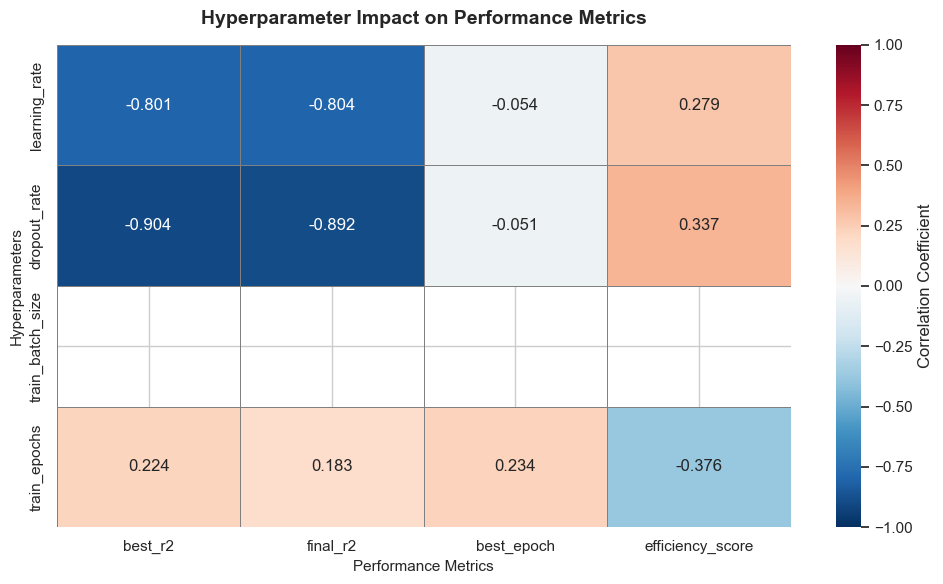

✓ Saved hyperparameter impact heatmap to `hyperparameter_impact_heatmap.png`

\n**Heatmap Interpretation:**
• Strong positive correlation (red): Increasing hyperparameter improves metric
• Strong negative correlation (blue): Increasing hyperparameter decreases metric
• Near-zero correlation (white): Little to no linear relationship
\n**Strongest Relationships:**
  1. train_batch_size correlates negatively with efficiency_score (r=nan)
  2. train_batch_size correlates negatively with best_epoch (r=nan)
  3. train_batch_size correlates negatively with final_r2 (r=nan)


In [14]:
if not config_history.empty:
    # Select hyperparameter columns and performance metrics
    hyperparam_cols = [col for col in ["learning_rate", "dropout_rate", "train_batch_size", "train_epochs"] 
                       if col in config_history.columns]
    
    metric_cols = [col for col in ["best_r2", "final_r2", "total_training_time", "best_epoch"] 
                   if col in config_history.columns]
    
    if hyperparam_cols and metric_cols:
        # Create correlation matrix
        analysis_df = config_history[hyperparam_cols + metric_cols].copy()
        
        # Normalize total_training_time to be on similar scale (invert so higher is better)
        if "total_training_time" in analysis_df.columns:
            max_time = analysis_df["total_training_time"].max()
            analysis_df["efficiency_score"] = 1 - (analysis_df["total_training_time"] / max_time)
            metric_cols.append("efficiency_score")
            metric_cols.remove("total_training_time")
        
        # Calculate correlation matrix
        corr_matrix = analysis_df[hyperparam_cols + metric_cols].corr()
        
        # Extract hyperparameter vs metric correlations
        hp_metric_corr = corr_matrix.loc[hyperparam_cols, metric_cols]
        
        # Visualization
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.heatmap(hp_metric_corr, annot=True, fmt=".3f", cmap="RdBu_r", 
                    center=0, vmin=-1, vmax=1, 
                    cbar_kws={"label": "Correlation Coefficient"},
                    linewidths=0.5, linecolor='gray', ax=ax)
        
        ax.set_title("Hyperparameter Impact on Performance Metrics", fontsize=14, fontweight="bold", pad=15)
        ax.set_xlabel("Performance Metrics", fontsize=11)
        ax.set_ylabel("Hyperparameters", fontsize=11)
        
        plt.tight_layout()
        heatmap_path = paths["figures_dir"] / "hyperparameter_impact_heatmap.png"
        plt.savefig(heatmap_path, dpi=300, bbox_inches="tight")
        plt.show()
        
        display(Markdown(f"✓ Saved hyperparameter impact heatmap to `{heatmap_path.name}`"))
        
        # Interpretation
        print("\\n**Heatmap Interpretation:**")
        print("• Strong positive correlation (red): Increasing hyperparameter improves metric")
        print("• Strong negative correlation (blue): Increasing hyperparameter decreases metric")
        print("• Near-zero correlation (white): Little to no linear relationship")
        
        # Find strongest relationships
        flat_corr = hp_metric_corr.abs().values.flatten()
        flat_indices = np.argsort(flat_corr)[::-1]
        
        print("\\n**Strongest Relationships:**")
        for i in range(min(3, len(flat_indices))):
            row_idx = flat_indices[i] // len(metric_cols)
            col_idx = flat_indices[i] % len(metric_cols)
            
            hp = hp_metric_corr.index[row_idx]
            metric = hp_metric_corr.columns[col_idx]
            corr_value = hp_metric_corr.iloc[row_idx, col_idx]
            
            direction = "positively" if corr_value > 0 else "negatively"
            print(f"  {i+1}. {hp} correlates {direction} with {metric} (r={corr_value:.3f})")
    
    else:
        print("⚠ Insufficient historical data for hyperparameter impact analysis")
else:
    print("⚠ No configuration history available for hyperparameter impact analysis")

## 7. Summary and Recommendations

### Key Findings and Action Items

In [15]:
# Generate comprehensive summary report
summary_findings = []

# 1. Training performance
best_val_loss = results_df["val_loss"].min()
final_val_loss = results_df.iloc[-1]["val_loss"]
best_r2 = results_df["r2_score"].max()

summary_findings.append({
    "Category": "Training Performance",
    "Finding": f"Best validation loss: {best_val_loss:.4f} at epoch {results_df['val_loss'].idxmin()}",
    "Status": "✓" if best_val_loss < 0.1 else "⚠",
    "Action": "Continue training if best epoch near end" if results_df["val_loss"].idxmin() > len(results_df) * 0.8 else "No action needed"
})

summary_findings.append({
    "Category": "Model Accuracy",
    "Finding": f"Peak R² score: {best_r2:.4f}",
    "Status": "✓" if best_r2 > 0.8 else "⚠" if best_r2 > 0.6 else "✗",
    "Action": "Excellent performance" if best_r2 > 0.9 else "Consider architecture changes" if best_r2 < 0.7 else "Minor tuning recommended"
})

# 2. Generalization
final_gap = results_df.iloc[-1]["train_val_gap"]

summary_findings.append({
    "Category": "Generalization",
    "Finding": f"Train/val gap: {final_gap:.4f}",
    "Status": "✓" if final_gap < 0.05 else "⚠" if final_gap < 0.1 else "✗",
    "Action": "Good generalization" if final_gap < 0.05 else "Increase regularization (dropout)" if final_gap > 0.1 else "Monitor closely"
})

# 3. Convergence stability
loss_std = results_df.tail(10)["val_loss"].std()

summary_findings.append({
    "Category": "Convergence Stability",
    "Finding": f"Loss std (last 10 epochs): {loss_std:.4f}",
    "Status": "✓" if loss_std < 0.01 else "⚠",
    "Action": "Stable convergence" if loss_std < 0.01 else "Consider learning rate schedule"
})

# 4. Prediction quality
if residual_metrics:
    mae = residual_metrics.get("mae", float('inf'))
    
    summary_findings.append({
        "Category": "Prediction Quality",
        "Finding": f"Mean absolute error: {mae:.4f}",
        "Status": "✓" if mae < 0.5 else "⚠" if mae < 1.0 else "✗",
        "Action": "Excellent predictions" if mae < 0.5 else "Review feature engineering" if mae > 1.0 else "Minor improvements possible"
    })

# 5. Computational efficiency
avg_epoch_time = results_df.tail(10)["epoch_time"].mean()
total_time = results_df["epoch_time"].sum()

summary_findings.append({
    "Category": "Computational Efficiency",
    "Finding": f"Avg epoch time: {avg_epoch_time:.2f}s | Total: {total_time:.1f}s",
    "Status": "✓" if avg_epoch_time < 5.0 else "⚠",
    "Action": "Efficient training" if avg_epoch_time < 5.0 else "Consider batch size optimization"
})

# 6. Weight constraint effectiveness (if James-Stein comparison was run)
if 'comparison_results' in locals() and comparison_results:
    bc_best = comparison_results["Binary Constraints"]["best_val_loss"]
    js_best = comparison_results["James-Stein"]["best_val_loss"]
    nc_best = comparison_results["No Constraints"]["best_val_loss"]
    
    if bc_best < min(js_best, nc_best):
        constraint_status = "✓"
        constraint_action = "Binary constraints are most effective"
    elif js_best < min(bc_best, nc_best):
        constraint_status = "⚠"
        constraint_action = "Consider switching to James-Stein shrinkage"
    else:
        constraint_status = "⚠"
        constraint_action = "Constraints may not be beneficial for this problem"
    
    summary_findings.append({
        "Category": "Weight Constraints",
        "Finding": f"Best: Binary={bc_best:.4f}, JS={js_best:.4f}, None={nc_best:.4f}",
        "Status": constraint_status,
        "Action": constraint_action
    })

summary_df = pd.DataFrame(summary_findings)

display(Markdown("### Executive Summary"))
display(summary_df)

# Count status indicators
success_count = (summary_df["Status"] == "✓").sum()
warning_count = (summary_df["Status"] == "⚠").sum()
critical_count = (summary_df["Status"] == "✗").sum()

print(f"\\nOverall Assessment:")
print(f"  ✓ Success indicators: {success_count}")
print(f"  ⚠ Warning indicators: {warning_count}")
print(f"  ✗ Critical issues: {critical_count}")

if critical_count > 0:
    print("\\n⚠️ CRITICAL ISSUES DETECTED - Immediate attention required")
elif warning_count > 2:
    print("\\n⚠ Multiple warnings detected - Review recommendations carefully")
else:
    print("\\n✓ Training appears healthy overall")

# Prioritized action items
display(Markdown("### Prioritized Action Items"))

action_items = []

# From recommendations
if 'recommendations_df' in locals() and not recommendations_df.empty:
    high_priority_recs = recommendations_df[recommendations_df["Priority"] == "High"]
    
    for idx, row in high_priority_recs.iterrows():
        action_items.append({
            "Priority": 1,
            "Action": f"Adjust {row['Parameter']}: {row['Suggested'][0] if isinstance(row['Suggested'], list) else row['Suggested']}",
            "Rationale": row['Rationale'],
            "Expected Impact": row['Expected Impact']
        })

# From summary findings
for idx, row in summary_df.iterrows():
    if row["Status"] == "✗":
        action_items.append({
            "Priority": 1,
            "Action": row['Action'],
            "Rationale": row['Finding'],
            "Expected Impact": "Critical improvement needed"
        })
    elif row["Status"] == "⚠" and row["Action"] not in ["Monitor closely", "Minor tuning recommended"]:
        action_items.append({
            "Priority": 2,
            "Action": row['Action'],
            "Rationale": row['Finding'],
            "Expected Impact": "Performance optimization"
        })

# Sort by priority
action_items_df = pd.DataFrame(action_items)

if not action_items_df.empty:
    action_items_df = action_items_df.sort_values("Priority").reset_index(drop=True)
    action_items_df.index = action_items_df.index + 1  # Start from 1
    display(action_items_df)
else:
    print("✓ No critical action items. System is performing well.")
    print("\\nOptional improvements:")
    print("  • Fine-tune hyperparameters with small perturbations")
    print("  • Explore ensemble methods for marginal gains")
    print("  • Consider transfer learning if applicable")

### Executive Summary

,Category,Finding,Status,Action
0,Training Performance,Best validation loss: 0.0898 at epoch 151,✓,No action needed
1,Model Accuracy,Peak R² score: 0.9145,✓,Excellent performance
2,Generalization,Train/val gap: -0.0135,✓,Good generalization
3,Convergence Stability,Loss std (last 10 epochs): 0.0042,✓,Stable convergence
4,Prediction Quality,Mean absolute error: 2.2493,✗,Review feature engineering
5,Computational Efficiency,Avg epoch time: 3.63s | Total: 718.8s,✓,Efficient training
6,Weight Constraints,"Best: Binary=0.0993, JS=1.0649, None=0.0989",⚠,Constraints may not be beneficial for this pro...


\nOverall Assessment:
  ✓ Success indicators: 5
  ⚠ Warning indicators: 1
  ✗ Critical issues: 1
\n⚠️ CRITICAL ISSUES DETECTED - Immediate attention required


### Prioritized Action Items

,Priority,Action,Rationale,Expected Impact
1,1,Adjust learning_rate: 0.001,Validation loss plateaued (slope ≈ 0). Try var...,±10-30% validation loss change
2,1,Review feature engineering,Mean absolute error: 2.2493,Critical improvement needed
3,2,Constraints may not be beneficial for this pro...,"Best: Binary=0.0993, JS=1.0649, None=0.0989",Performance optimization


### Analysis Artifacts and Export Summary

In [16]:
# List all generated figures
figures_dir = paths["figures_dir"]
generated_figures = list(figures_dir.glob("*.png"))

display(Markdown(f"### Generated Visualizations ({len(generated_figures)} files)"))

figure_summary = []

for fig_path in sorted(generated_figures):
    size_kb = fig_path.stat().st_size / 1024
    
    figure_summary.append({
        "Filename": fig_path.name,
        "Size (KB)": f"{size_kb:.1f}",
        "Modified": pd.Timestamp(fig_path.stat().st_mtime, unit="s").strftime("%Y-%m-%d %H:%M:%S")
    })

figure_summary_df = pd.DataFrame(figure_summary)

if not figure_summary_df.empty:
    display(figure_summary_df)
    print(f"\\nAll figures saved to: {figures_dir}")
else:
    print("No figures generated in this session")

# Export summary statistics to JSON
summary_export = {
    "analysis_timestamp": pd.Timestamp.now().isoformat(),
    "model_checkpoint_epoch": checkpoint_meta["epoch"] if checkpoint_meta else None,
    "best_validation_loss": float(results_df["val_loss"].min()),
    "best_r2_score": float(results_df["r2_score"].max()),
    "final_train_val_gap": float(results_df.iloc[-1]["train_val_gap"]),
    "total_training_epochs": int(results_df.iloc[-1]["epoch"]),
    "total_training_time_seconds": float(results_df["epoch_time"].sum()),
    "average_epoch_time_seconds": float(results_df["epoch_time"].mean()),
    "prediction_mae": float(residual_metrics.get("mae", 0)) if residual_metrics else None,
    "prediction_rmse": float(residual_metrics.get("rmse", 0)) if residual_metrics else None,
    "artifacts_generated": len(generated_figures),
    "recommendations_count": len(recommendations_df) if 'recommendations_df' in locals() else 0
}

# Add James-Stein comparison results if available
if 'comparison_results' in locals() and comparison_results:
    summary_export["james_stein_comparison"] = {
        "binary_constraints_best_loss": float(comparison_results["Binary Constraints"]["best_val_loss"]),
        "james_stein_best_loss": float(comparison_results["James-Stein"]["best_val_loss"]),
        "no_constraints_best_loss": float(comparison_results["No Constraints"]["best_val_loss"]),
        "winner": min(comparison_results.items(), key=lambda x: x[1]["best_val_loss"])[0]
    }

summary_json_path = paths["analysis_dir"] / f"analysis_summary_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.json"

with open(summary_json_path, 'w') as f:
    json.dump(summary_export, f, indent=2)

display(Markdown(f"\\n✓ Exported analysis summary to `{summary_json_path.name}`"))

print("\\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"\\nSession timestamp: {summary_export['analysis_timestamp']}")
print(f"Figures directory: {figures_dir}")
print(f"Summary JSON: {summary_json_path}")
print("\\nNext steps:")
print("  1. Review high-priority recommendations")
print("  2. Implement suggested hyperparameter changes")
print("  3. Re-run training with updated configuration")
print("  4. Re-execute this notebook to track improvements")
print("\\nFor questions or issues, refer to the README.md documentation.")

### Generated Visualizations (13 files)

,Filename,Size (KB),Modified
0,baseline_comparison.png,128.2,2025-10-19 18:08:28
1,hyperparameter_impact_heatmap.png,191.3,2025-10-19 18:09:06
2,james_stein_comparison.png,506.8,2025-10-19 18:09:05
3,learning_rate_analysis.png,250.7,2025-10-19 18:08:23
4,learning_rate_vs_r2.png,70.9,2025-10-09 02:01:10
5,loss_curves.png,56.0,2025-10-09 02:01:09
6,metric_correlation_heatmap.png,88.8,2025-10-09 02:01:10
7,prediction_scatter_plots.png,1027.1,2025-10-19 18:08:26
8,residual_analysis_suite.png,854.0,2025-10-19 18:08:24
9,residual_distribution_by_target.png,79.4,2025-10-09 02:01:10


\nAll figures saved to: c:\Users\jesse\OneDrive\Documents\Programming Projects\Neural Network Lab - Python\neural-network-lab-python\training_output\analysis\figures


\n✓ Exported analysis summary to `analysis_summary_20251019_130906.json`

\n================================================================================
ANALYSIS COMPLETE
\nSession timestamp: 2025-10-19T13:09:06.598744
Figures directory: c:\Users\jesse\OneDrive\Documents\Programming Projects\Neural Network Lab - Python\neural-network-lab-python\training_output\analysis\figures
Summary JSON: c:\Users\jesse\OneDrive\Documents\Programming Projects\Neural Network Lab - Python\neural-network-lab-python\training_output\analysis\analysis_summary_20251019_130906.json
\nNext steps:
  1. Review high-priority recommendations
  2. Implement suggested hyperparameter changes
  3. Re-run training with updated configuration
  4. Re-execute this notebook to track improvements
\nFor questions or issues, refer to the README.md documentation.
